# Demographic Heterogeneity and Health Care Expenditures in Danish Municipalities

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
%load_ext autoreload
%autoreload 2

# if you wish to use one of the lines below it should probably be done in a new cell with one package at a time
# pip install git+https://github.com/alemartinello/dstapi # this can also be installed locally by cloning the repository and using pip install -e local-path;
# pip install ipywidgets
# pip install linearmodels


import pandas as pd
import numpy as np
from dstapi import DstApi

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from IPython.display import display,clear_output
import matplotlib.pyplot as plt
import matplotlib
import time

import pandas as pd

from linearmodels import PanelOLS
import statsmodels.api as sm

# user written modules
# import dataproject

load = False # if you dont want to wait for the data to be loaded from dstapi set this to True


# Read and clean data

The first data set we import is the population by age for each municipality in Denmark

In [2]:
ind = DstApi('FOLK1A') # connecting to dst API
tabsum = ind.tablesummary(language='en')
tabsum  # presenting summary of data

Table FOLK1A: Population at the first day of the quarter by region, sex, age, marital status and time
Last update: 2023-02-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,105,000,All Denmark,851,Aalborg,False
1,KØN,3,TOT,Total,2,Women,False
2,ALDER,127,IALT,Total,125,125 years,False
3,CIVILSTAND,5,TOT,Total,F,Divorced,False
4,Tid,61,2008K1,2008Q1,2023K1,2023Q1,True


In [3]:
# we are only interested in municipalities and not regions, so we loop thrugh all variables

# importing data
params = {'table':'FOLK1A',
         'format':"BULK",
         'variables':[{'code':'OMRÅDE','values':['*']},
                     {'code':'KØN','values':['*']},
                     {'code':'ALDER','values':['*']},
                     {'code':'Tid','values':['*']},
                     {'code':'CIVILSTAND','values':['TOT']}]}

if load:
    data = pd.read_csv('dataX.csv',index_col=0)
else:
    data = ind.get_data(params)
    # storing data in csv
    data.to_csv('dataX.csv')

print(f'Shape of data {data.shape}')


Shape of data (1977746, 6)


In [4]:
# cleaning the data

# the data is quartlery and set up as YYYYKX, we change the K to a Q such as it can be converted to datetime 
data['TID'] = pd.to_datetime(data.reset_index()['TID'].apply(lambda x: x.replace('K','Q')))
# keep a selected number of columns
data = data[data['KØN']=='I alt'][['TID','OMRÅDE','ALDER','INDHOLD']]
# create column with the yearly value
data['ÅR'] = data['TID'].dt.year
# discard the three other quarterly observations
data = data.groupby(['ÅR','OMRÅDE','ALDER']).last()
# reset index
data = data.reset_index()
# dropping the original time denomination
data = data.drop(columns = ['TID'])
# convert the yearly column into integer type
data['ÅR'] = data['ÅR'].astype(int)
# discar the total population in each municipality
data = data[data['ALDER'] != 'I alt']
# convert age column into integers
data['ALDER'] = data['ALDER'].str.strip(' år')
data['ALDER'] = data['ALDER'].astype(int)

The second data set we import is the health care expenditures for each danish municipality from 2008-2022

In [5]:
# connecting to dst
ind = DstApi('REGK11')

# choosing which variables to import
params = {'table':'REGK11',
        'format':"BULK",
        'variables':[{'code':'OMRÅDE','values':['*']},
                    {'code':'PRISENHED','values':['INDL']},
                    {'code':'DRANST','values':['1']},
                    {'code':'FUNK1','values':['4']},
                    {'code':'ART','values':['TOT']},
                    {'code':'TID','values':['>2007']}]}
# importing data from API or csv
if load:
        HC_EXP = pd.read_csv('dataY.csv',index_col=0)
else:
        HC_EXP = ind.get_data(params)

        # storing data in csv
        HC_EXP.to_csv('dataY.csv')

# dropping irrelevant and/or constant columns
HC_EXP.drop(columns=['PRISENHED', 'DRANST', 'FUNK1', 'ART'],inplace=True)

# renaming columns
HC_EXP.rename(columns={'INDHOLD':'SUNDHEDSUDGIFTER'},inplace=True)

print(f'This dataset has has shape {HC_EXP.shape}')

This dataset has has shape (1526, 3)


The difference in datashapes is due to the latter dataset, not having age indexes for each municipality and containing regions and municipality groups as well

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [6]:
# renaming to merge later
HC_EXP.rename(columns={'TID':'ÅR'},inplace=True)
# merging on municipality and year, we discard all non-municpality observations in HC_EXP
new_df = pd.merge(data, HC_EXP,  how='left', left_on=['OMRÅDE','ÅR'], right_on = ['OMRÅDE','ÅR'])
# calculating the total population in each municipality
samlet_bef = new_df.groupby(['ÅR','OMRÅDE'])['INDHOLD'].sum()
# creaing new column for old people for convenience
new_df['GAMLE'] = new_df['INDHOLD']
new_df.loc[new_df['ALDER']<60,'GAMLE'] = 0
# calculating the total number of old people in each municipality
samlet_bef1 = new_df.groupby(['ÅR','OMRÅDE'])['GAMLE'].sum()
df_ = pd.merge(samlet_bef, samlet_bef1,  how='left', left_on=['OMRÅDE','ÅR'], right_on = ['OMRÅDE','ÅR'])
df_['ANDEL'] = df_['GAMLE']/df_['INDHOLD']
# renaming columns and creating final merging
df_.rename(columns={'INDHOLD':'SAMLET BEFOLKNING'},inplace=True)
df_ = pd.merge(df_,HC_EXP,how='left', left_on=['OMRÅDE','ÅR'], right_on = ['OMRÅDE','ÅR'])

print(f'The merged dataset has shape {df_.shape}')

The merged dataset has shape (1680, 6)


In [7]:
# Unique OMRÅDER (areas) in our dataset
print(pd.unique(df_.OMRÅDE))

['Aabenraa' 'Aalborg' 'Aarhus' 'Albertslund' 'Allerød' 'Assens' 'Ballerup'
 'Billund' 'Bornholm' 'Brøndby' 'Brønderslev' 'Christiansø' 'Dragør'
 'Egedal' 'Esbjerg' 'Faaborg-Midtfyn' 'Fanø' 'Favrskov' 'Faxe'
 'Fredensborg' 'Fredericia' 'Frederiksberg' 'Frederikshavn'
 'Frederikssund' 'Furesø' 'Gentofte' 'Gladsaxe' 'Glostrup' 'Greve'
 'Gribskov' 'Guldborgsund' 'Haderslev' 'Halsnæs' 'Hedensted' 'Hele landet'
 'Helsingør' 'Herlev' 'Herning' 'Hillerød' 'Hjørring' 'Holbæk' 'Holstebro'
 'Horsens' 'Hvidovre' 'Høje-Taastrup' 'Hørsholm' 'Ikast-Brande' 'Ishøj'
 'Jammerbugt' 'Kalundborg' 'Kerteminde' 'Kolding' 'København' 'Køge'
 'Langeland' 'Lejre' 'Lemvig' 'Lolland' 'Lyngby-Taarbæk' 'Læsø'
 'Mariagerfjord' 'Middelfart' 'Morsø' 'Norddjurs' 'Nordfyns' 'Nyborg'
 'Næstved' 'Odder' 'Odense' 'Odsherred' 'Randers' 'Rebild'
 'Region Hovedstaden' 'Region Midtjylland' 'Region Nordjylland'
 'Region Sjælland' 'Region Syddanmark' 'Ringkøbing-Skjern' 'Ringsted'
 'Roskilde' 'Rudersdal' 'Rødovre' 'Samsø' 'Silke

In [8]:
# Creating a seperate dataframe for Danish regions

regs = ['Region Hovedstaden','Region Sjælland','Region Syddanmark','Region Midtjylland','Region Nordjylland']
df_regs = pd.DataFrame()
for r in regs:
    df_regs = pd.concat([df_regs,df_.loc[df_['OMRÅDE']==r]])# appending to regional dataframe
    df_.drop(df_.loc[df_['OMRÅDE']==r].index,inplace=True)  # dropping from municipality dataset

The merged dataset containt 98 municipalities, and Christiansø. Yielding 99 "municipalities" (for simplicity we consider Christiansø a municipality, although this probably contaminates the estimation results below). And observations for each year in the period 2008-2023

## Explore each data set

Below we first show a positive relationship between our two variables, using a panel regression and afterwards we make an interactive plot to explore the demographic decomposition of each municipality over time

**Interactive plot** :

In [9]:
#Fixed Effects Regression between expenses and share of old people
df_reg = sm.add_constant(df_)
df_reg = df_reg.set_index(['OMRÅDE','ÅR']).dropna() # by removing all NaN values we end up with 1386 rows

mod = PanelOLS(dependent = df_reg[['SUNDHEDSUDGIFTER']], 
                   exog = df_reg[['const','ANDEL']],
                   entity_effects=True,
                    time_effects=True,
                   check_rank=False,
                  drop_absorbed=True)
    
re_res = mod.fit(cov_type='robust')
# the results are presented in the analysis section

In [10]:
def plot_graph1(change=None):
    plot_graph_1(output_widget)

def plot_graph2(change=None):
    plot_graph_2(output_widget2)

def plot_graph_1(output):
    year = year_slider.value
    municipal = municipal_slider.value
    
    # Filter the DataFrame based on the selected year and municipal
    filtered_df = data[data['ÅR'] == year]
    filtered_df = filtered_df[filtered_df['OMRÅDE'].isin(municipal)]

    # Create the bar plot
    plt.barh(filtered_df['ALDER'].unique(), filtered_df['INDHOLD'])
    plt.title(f"Values for year {year}")
    plt.xlabel("Number")
    plt.ylabel("Age")
    plt.tight_layout()

    # Display the graph in the output widget
    with output:
        output.clear_output(wait=True)
        display(plt.gcf())
        
    plt.clf()
    
def plot_graph_2(output):

    year = year_slider.value
    municipal = municipal_slider.value
    
    filtered_df = df_[df_['OMRÅDE'].isin(municipal)]
    
    xx = filtered_df['ANDEL']
    yy = filtered_df['SUNDHEDSUDGIFTER']
    
    # plt.scatter(xx,yy)
    plt.plot(xx,yy,marker='o')
    
    plt.text(x=filtered_df['ANDEL'].min(), y=filtered_df['SUNDHEDSUDGIFTER'].max()+300, s=f'$Health_care_expenses_t$ = {round(re_res.params[0],2)} + {round(re_res.params[1],2)} $Share_t$')

    for i, txt in enumerate(filtered_df['ÅR'].unique()):
        plt.annotate(txt, (xx.values[i], yy.values[i]))
    plt.xlabel('Share of population $\geq$60 years')
    plt.ylabel('Health care expenditure per capita, DKK')
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
    with output:
        output.clear_output(wait=True)
        display(plt.gcf())

        
    plt.clf()

# Create the year slider
year_slider = widgets.IntSlider(
    value=data['ÅR'].min(),
    min=data['ÅR'].min(),
    max=data['ÅR'].max(),
    step=1,
    description="Year:",
    continuous_update=True,
)

# Create the municipal slider
municipal_slider = widgets.SelectMultiple(
    options=data['OMRÅDE'].unique(),
    value=['Ærø'],
    description='Municipal:',
    disabled=False,
)

# Create the output widgets
output_widget = widgets.Output()
output_widget2 = widgets.Output()

# Observe the slider changes and update the graphs
year_slider.observe(plot_graph1, names='value')
municipal_slider.observe(plot_graph1, names='value')

year_slider.observe(plot_graph2, names='value')
municipal_slider.observe(plot_graph2, names='value')

# Create a 2x2 GridBox layout
layout = widgets.GridBox(
    children=[year_slider, municipal_slider, output_widget, output_widget2],
    layout=widgets.Layout(
        width='100%',
        grid_template_columns='50% 50%',
        grid_template_rows='25% 50%',
        grid_gap='10px',
        grid_template_areas='''
            "year_slider municipal_slider"
            "output_widget output_widget2"
        ''')
)

# Initialize the graphs
plot_graph1()
plot_graph2()

# Display the GridBox layout
display(layout)


GridBox(children=(IntSlider(value=2008, description='Year:', max=2023, min=2008), SelectMultiple(description='…

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

When changing the municipality a positive correlation between the share of old people, and health care expenses emerges. With a few exceptions, furthermore the share of old people are for most municipalities increasing over time, which is also evident from the horizontal bar plot, at the left hand side. Across different municipalities one more structural breaks in the health care expenditure development occurs, around 2012 or 2018. This is most likely due to policy changes. Either local changes e.g., repriotizing, preference changes or national changes, e.g., Kommunalreformer (Municipality reforms), Health Care reforms.

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

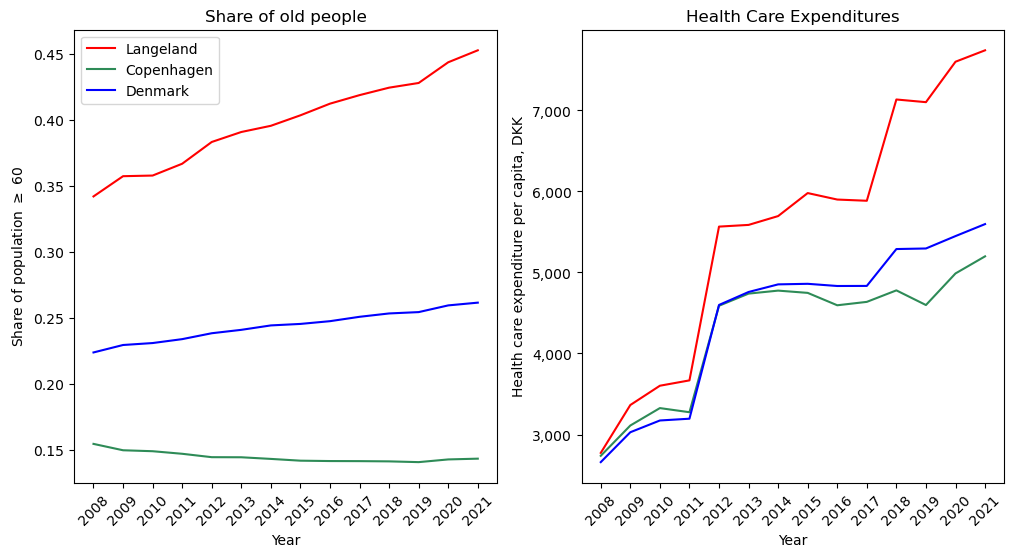

In [11]:
# Comparing two municipalities 
df_lang = df_.loc[df_["OMRÅDE"] == "Langeland"]
df_kob = df_.loc[df_["OMRÅDE"] == "København"]
df_DK = df_.loc[df_["OMRÅDE"] == "Hele landet"]

df_lang = df_lang[:-2]
df_kob = df_kob[:-2]
df_DK = df_DK[:-2]

N = len(df_lang["ÅR"])

ind = np.arange(N)  # the x locations for the groups

fig, ax = plt.subplots(1,2,figsize=(12,6),dpi=100)
ax[0].plot(ind,df_lang["ANDEL"], color='red',label='Langeland')
ax[0].plot(ind,df_kob["ANDEL"], color='seagreen',label='Copenhagen')
ax[0].plot(ind,df_DK["ANDEL"], color='blue',label='Denmark')

ax[0].set_xticks(ind)
ax[0].set_xticklabels( df_lang["ÅR"])

ax[0].legend()
ax[0].set_title('Share of old people')

ax[0].tick_params(axis='x', rotation=45)

ax[0].set_xlabel("Year")
ax[0].set_ylabel("Share of population $\geq$ 60")

ax[1].plot(ind,df_lang["SUNDHEDSUDGIFTER"], color='red',label='Langeland')
ax[1].plot(ind,df_kob["SUNDHEDSUDGIFTER"], color='seagreen',label='Copenhagen')
ax[1].plot(ind,df_DK["SUNDHEDSUDGIFTER"], color='blue',label='Copenhagen')

ax[1].set_xticks(ind)
ax[1].set_xticklabels( df_lang["ÅR"])

ax[1].tick_params(axis='x', rotation=45)

ax[1].set_title('Health Care Expenditures')

ax[1].set_xlabel("Year")
ax[1].set_ylabel('Health care expenditure per capita, DKK')
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

Copenhagen municipality containts the Danish capital and is the municipality with the highest population in Denmark. Langeland is a small island municipality at the coast of Funen, this is known as part of the peripheral Denmark. A side by side comparison of the two municiapalities illustrates the heterogeneity in demographic composition. Where the share of old people in Copenhagen has remained stable around 15 % from 2008 to 2021, while the share has increased from 35 % to 45 % in the same period. This difference in demographics also shows in the right hand side graph. Where the health care expenditures per capita of Langeland has increased from approximately 3,000 DKK to approximately 7,500 DKK, while in Copenhagen the health care expenditure increased from approximately 3,000 DKK to approximately 5,000 DKK. For comparison we include the same graphs for the whole country, to show why heterogeneity matters.

In [12]:
df_sum = df_[['SAMLET BEFOLKNING','SUNDHEDSUDGIFTER']].describe().astype(int)
df_sum.rename(columns={'SAMLET BEFOLKNING':'POPULATION','SUNDHEDSUDGIFTER':'HEALTH CARE EXPENDITURES'},inplace=True)
df_sum['SHARE OF OLD PEOPLE'] = df_['ANDEL'].describe()

df_sum

,POPULATION,HEALTH CARE EXPENDITURES,SHARE OF OLD PEOPLE
count,1600,1386,1600.000000
mean,114045,4586,0.275149
std,566115,1121,0.052655
min,93,2318,0.141086
25%,29667,3443,0.241376
50%,43117,4828,0.264314
75%,60439,5365,0.300614
max,5932654,7818,0.501954


Above we present some summary statistics of the population, health care expenses and share of old people. The differences in count is due to NaN values in health care expenses. We see the share of old people between the first and third quartile is relative close, while the outliers have a larger dispersion.

In [13]:
print(re_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       SUNDHEDSUDGIFTER   R-squared:                        0.1319
Estimator:                   PanelOLS   R-squared (Between):             -0.2625
No. Observations:                1386   R-squared (Within):               0.2402
Date:                Sun, Apr 16 2023   R-squared (Overall):              0.1868
Time:                        17:50:04   Log-likelihood                   -9384.3
Cov. Estimator:                Robust                                           
                                        F-statistic:                      193.49
Entities:                         100   P-value                           0.0000
Avg Obs:                       13.860   Distribution:                  F(1,1273)
Min Obs:                       0.0000                                           
Max Obs:                       14.000   F-statistic (robust):             97.937
                            

The above results, should not be interpreted as an thorough econometric analysis of the causality, but merely a superficial analysis showing a significant relationsship between the two variables.

We find a positive correlation between the share of elderly people and the health care expenditure per capita in danish municipalities. If the share of old people in a municipality increases by 10 percentage points the health care expenditures per capita increases by approximately 875 DKK.

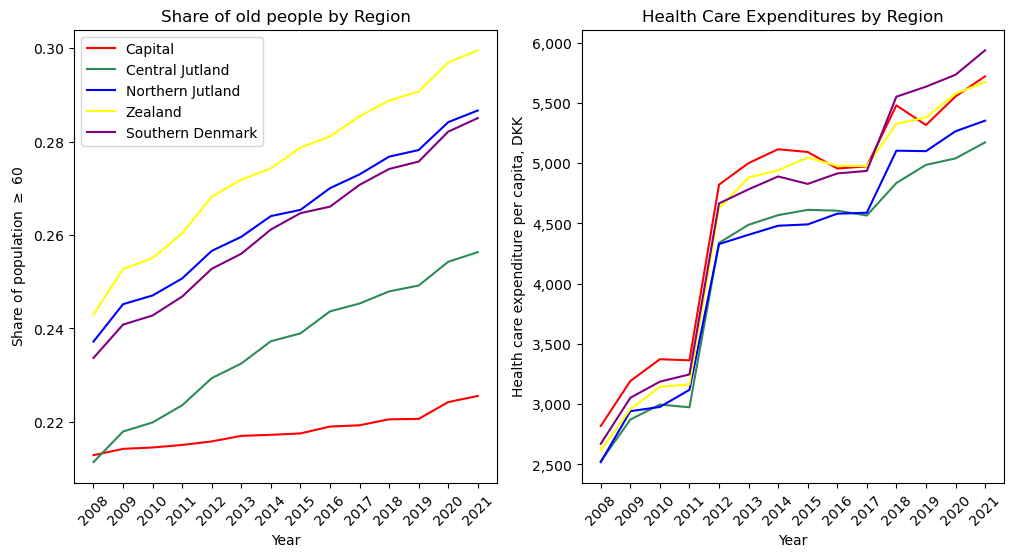

In [14]:
#Comparing the 5 regions
df_regh = df_regs.loc[df_regs["OMRÅDE"] == "Region Hovedstaden"]
df_regmj = df_regs.loc[df_regs["OMRÅDE"] == "Region Midtjylland"]
df_regnj = df_regs.loc[df_regs["OMRÅDE"] == "Region Nordjylland"]
df_regsj = df_regs.loc[df_regs["OMRÅDE"] == "Region Sjælland"]
df_regsy = df_regs.loc[df_regs["OMRÅDE"] == "Region Syddanmark"]

df_regh = df_regh[:-2]
df_regmj = df_regmj[:-2]
df_regnj = df_regnj[:-2]
df_regsj = df_regsj[:-2]
df_regsy = df_regsy[:-2]

N = len(df_regh["ÅR"])

ind = np.arange(N)  # the x locations for the groups

fig, ax = plt.subplots(1,2,figsize=(12,6),dpi=100)
ax[0].plot(ind, df_regh["ANDEL"], color='red',label='Capital')
ax[0].plot(ind, df_regmj["ANDEL"], color='seagreen',label='Central Jutland')
ax[0].plot(ind, df_regnj["ANDEL"], color='blue',label='Northern Jutland')
ax[0].plot(ind, df_regsj["ANDEL"], color='yellow',label='Zealand')
ax[0].plot(ind, df_regsy["ANDEL"], color='purple',label='Southern Denmark')

ax[0].set_xticks(ind)
ax[0].set_xticklabels( df_regh["ÅR"])

ax[0].set_title('Share of old people by Region')

ax[0].legend()

ax[0].tick_params(axis='x', rotation=45)

ax[0].set_xlabel("Year")
ax[0].set_ylabel("Share of population $\geq$ 60")

ax[1].plot(ind, df_regh["SUNDHEDSUDGIFTER"], color='red',label='Capital')
ax[1].plot(ind, df_regmj["SUNDHEDSUDGIFTER"], color='seagreen',label='Central Jutland')
ax[1].plot(ind, df_regnj["SUNDHEDSUDGIFTER"], color='blue',label='Northern Jutland')
ax[1].plot(ind, df_regsj["SUNDHEDSUDGIFTER"], color='yellow',label='Zealand')
ax[1].plot(ind, df_regsy["SUNDHEDSUDGIFTER"], color='purple',label='Southern Denmark')

ax[1].set_xticks(ind)
ax[1].set_xticklabels( df_regh["ÅR"])

ax[1].set_title('Health Care Expenditures by Region')

ax[1].tick_params(axis='x', rotation=45)

ax[1].set_xlabel("Year")
ax[1].set_ylabel('Health care expenditure per capita, DKK')
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

Above we show the development across regions, where the health care expenditures actually display similar behavior across all regions, despite the share of old people differing. The development in share of old people in regions are similar for all regions, except the capital region, which has seen a slower increase in share of old people. Highlighting one difference between country and city.

# Conclusion

We conclude there exist a positive correlation between the demographic composition and health care expenditures. We use the share of old people (defined as the share of people above 60 years) as a sufficient statistic for the demographic composition, we use municipality data as evidence for our conclusion. The heterogeneity of the age composition across Denmark has impliciations for policy makers, as different municipalities face different issues.